### OpenCV DNN 패키지를 이용하여 Faster R-CNN (Resnet-50)기반 Object Detection
https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

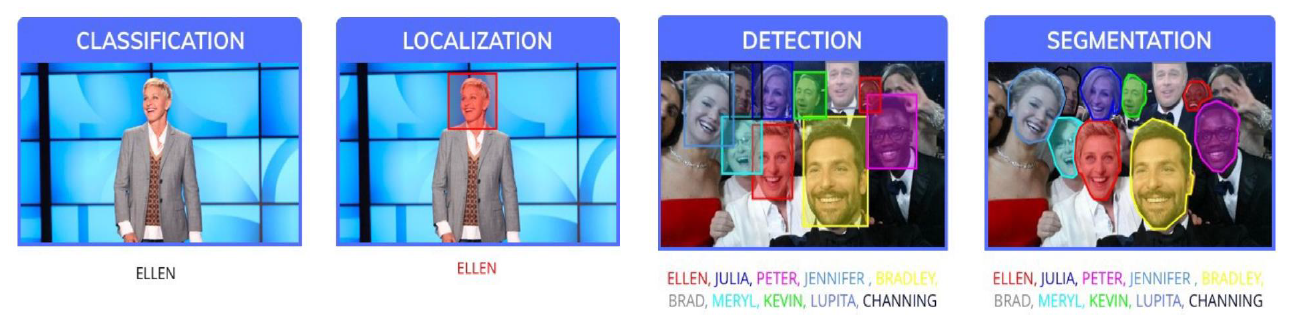

### - History of Objection Detection



### - R-CNN : 2 stage Detection   (Regions with CNN)
https://leechamin.tistory.com/215

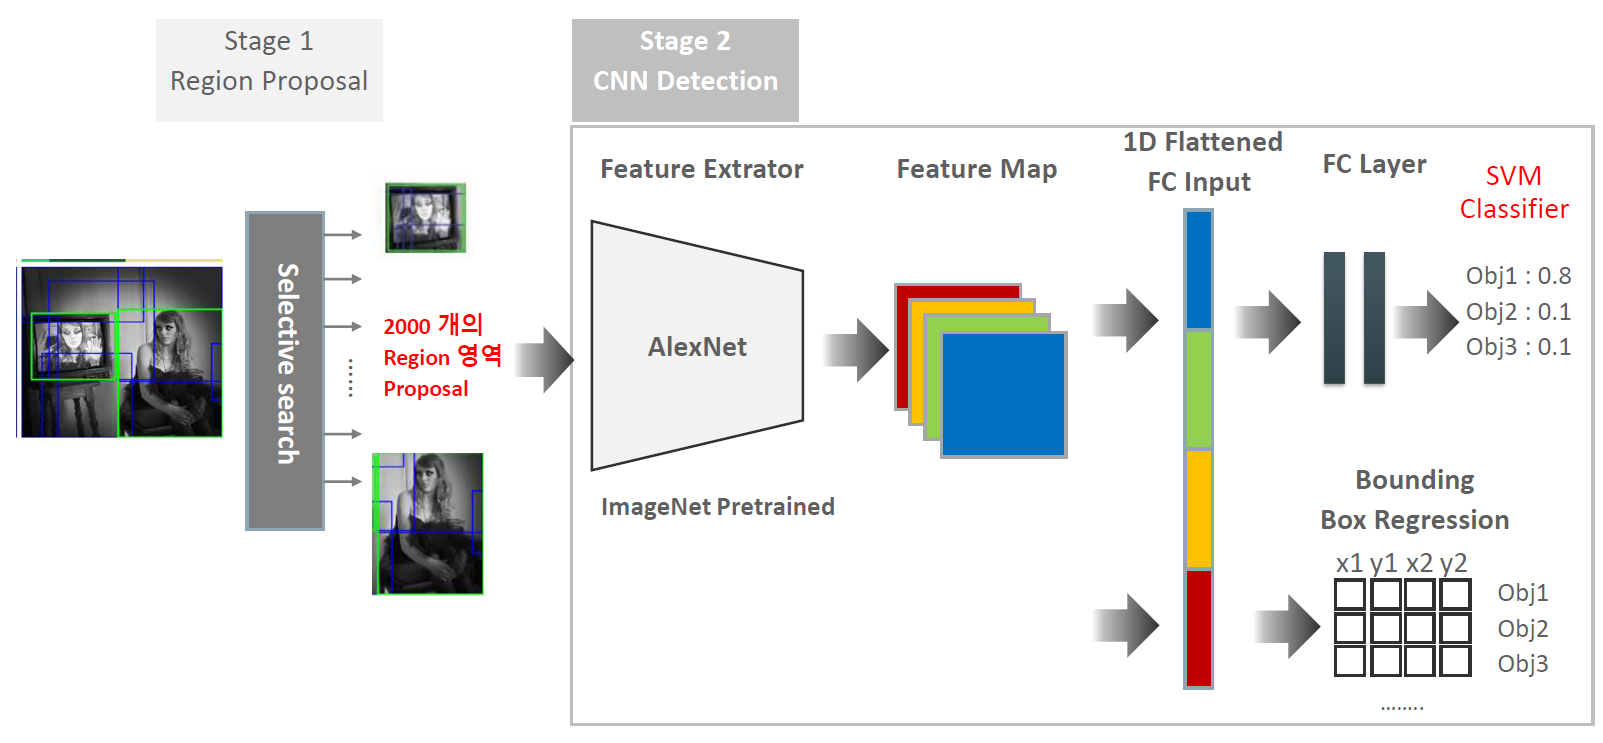

- 2000개의 Region 이미지를 CNN으로 입력 수행시간이 오래걸림
- Region 이미지가 동일한 사이즈로 변환해야하므로 warp 되어야함

## Bounding Box Regression

: Selective Search가 찾은 Box가 부정확하므로 Regression의 Weight을 사용하여 다시 교정

https://yeomko.tistory.com/13 <br>

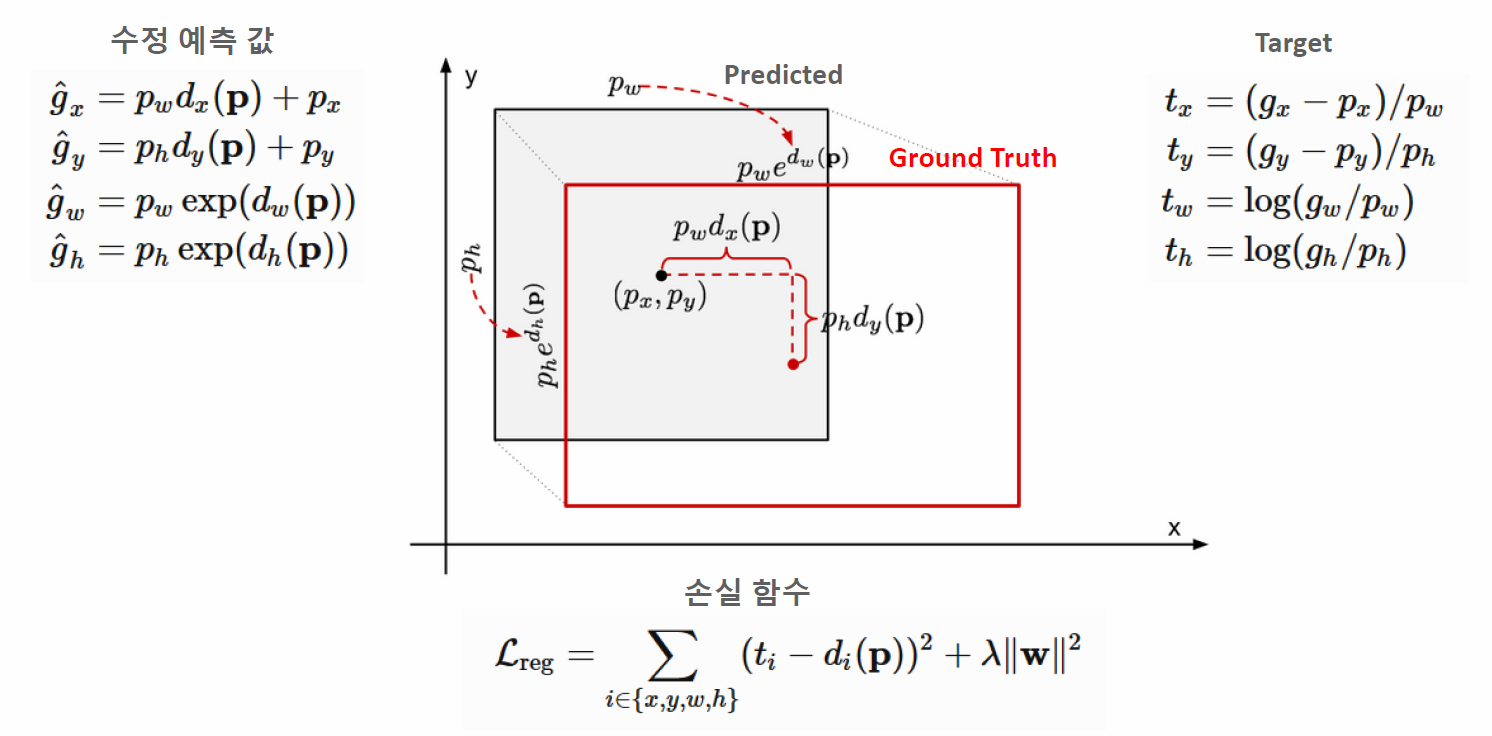

### - SPP-Net : Spatial Pyramid Pooling
https://yeomko.tistory.com/14
- 원본 이미지를 CNN에 입력하여 Feature Map을 생성하고 여기에서 Selective Search로 찾아진 영역을 추출
- SPP: CNN상에서 Image classification에서 서로 다른 이미지의 크기를 고정된 크기로 변환하는 기법

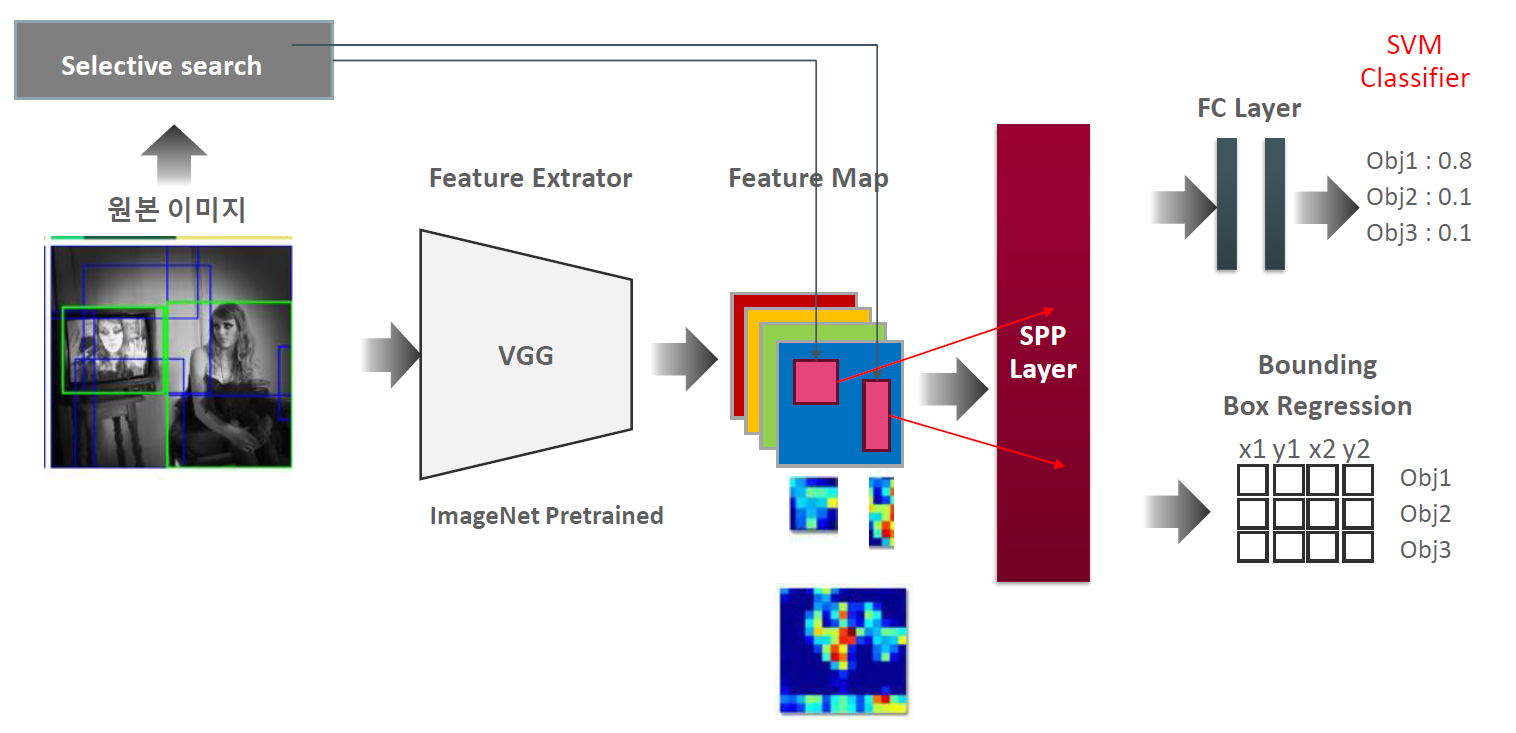

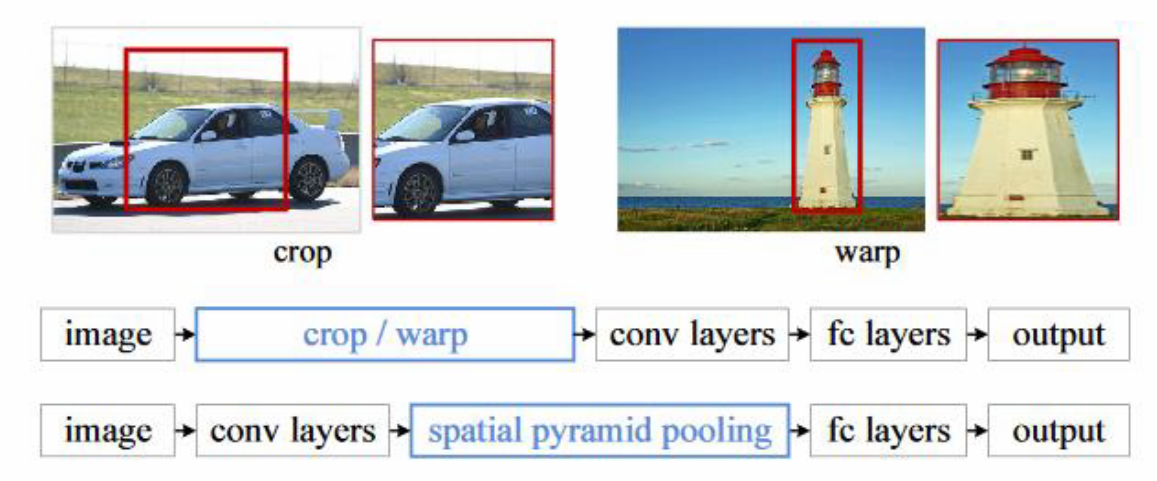

### - Fast R-CNN  : ROI(region of Interest) pooling
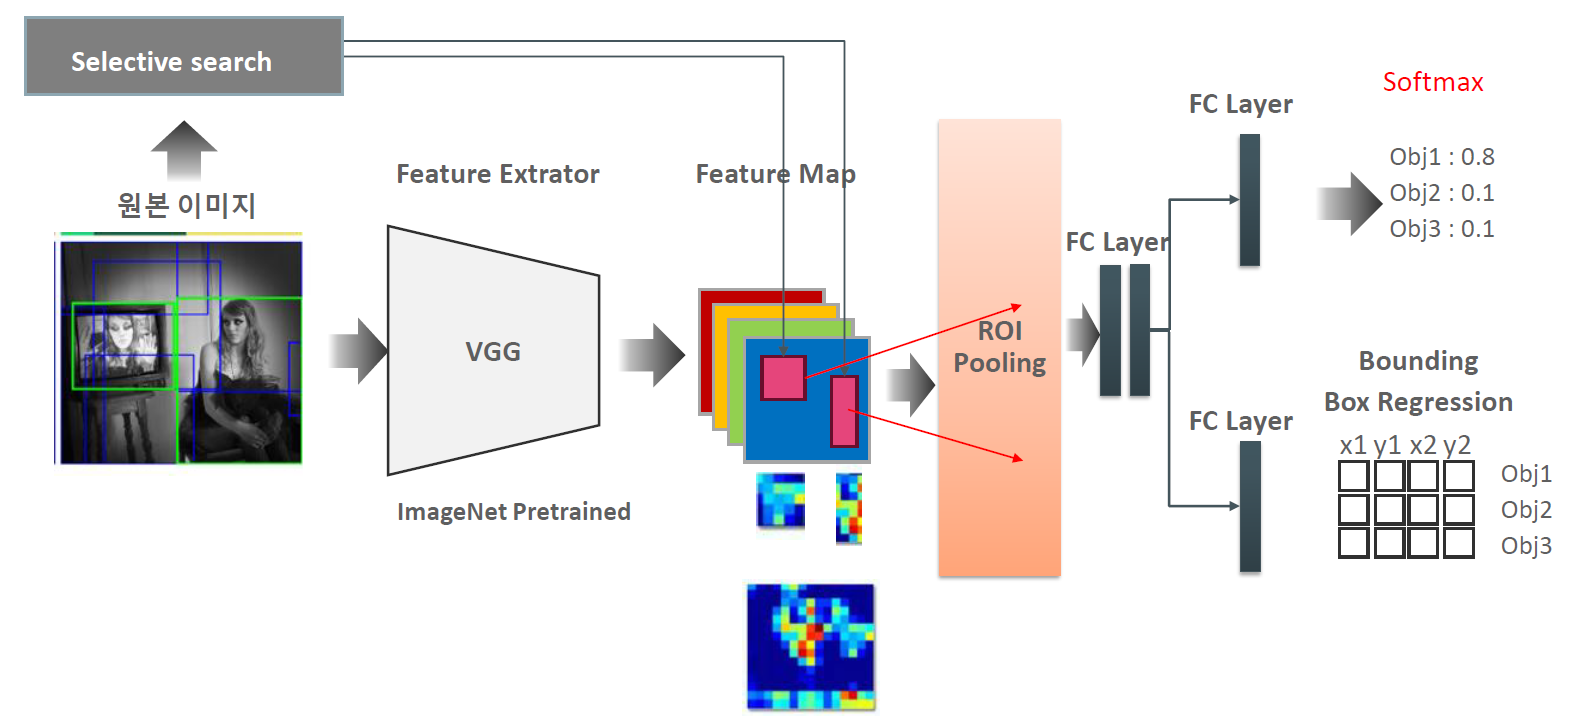

### - Faster R-CNN  

: Selective Search를 RPN(Region Proposal Network)으로 Neural Network 구조로 변경하여 GPU연산가능, <br>
    수행 속도가 빨라짐(5 FPS) 

https://yeomko.tistory.com/17 <br>
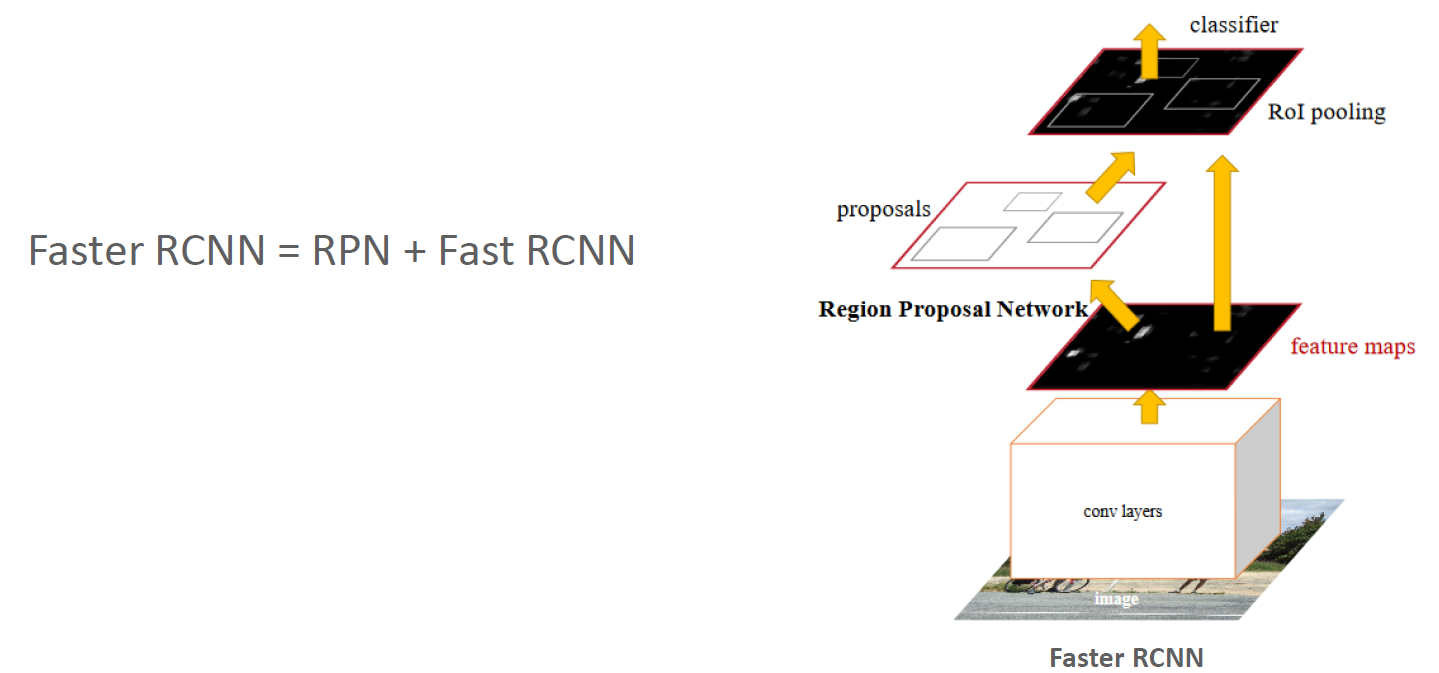

### 입력 이미지 준비

image shape: (419, 343, 3)


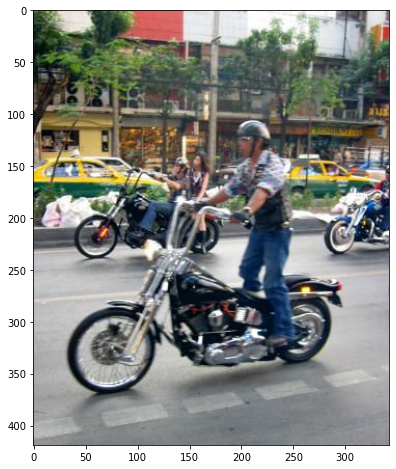

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 이미지를 cv2로 로드하고 matplotlib으로 시각화 
# img = cv2.imread('2008_003140.jpg')
img = cv2.imread('2008_005245.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('image shape:', img.shape)

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.show()

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt 에서 다운로드 
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함. 

#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [2]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/faster_rcnn_resnet50_coco_2018_01_28/graph.pbtxt')

In [3]:
# Tensorflow Faster RCNN 모델 : 이 소스에서 사용됨
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

In [4]:
# Tensorflow SSD모델
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}


In [5]:
# Darknet Yolo 모델 
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

### coco 데이터 셋의 클래스 id별 클래스명 지정


#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화 

(1, 1, 100, 7)
person: 0.9910
car: 0.8627
car: 0.7942
motorcycle: 0.9932
motorcycle: 0.9887
motorcycle: 0.9753


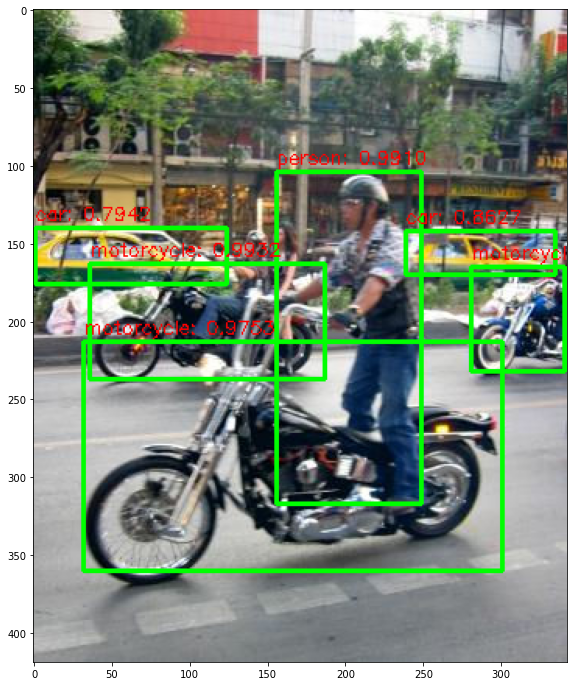

In [6]:
# 원본 이미지가 Faster RCNN기반 네트웍으로 입력 시 resize됨. 
# resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 size를 고정할 필요가 없는 것으로 추정. 
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)  # (1, 1, 100:detect한 object갯수 , 7 : ,id,score, 좌표 4개)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:  # 100회 반복
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score(IOU)가 0.5 이상만 추출
    if score > 0.5:
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
        caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
        print(caption)
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)    

#### 단일 이미지의 object detection을 함수로 생성

In [14]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            print(caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

In [15]:
# image 읽기
img = cv2.imread('beatles01.jpg')
print(img.shape)   # (633, 806, 3)

# Tensorflow Faster RCNN 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/faster_rcnn_resnet50_coco_2018_01_28/graph.pbtxt')

# Object Detetion 수행 
draw_img = get_detected_img(cv_net, img, score_threshold=0.5)

img_rgb = cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)

(633, 806, 3)
person: 0.9998
person: 0.9996
person: 0.9993
person: 0.9970
person: 0.8995
car: 0.8922
car: 0.7602
car: 0.7415
car: 0.6930
car: 0.6918
car: 0.6896
car: 0.6717
car: 0.6521
car: 0.5730
car: 0.5679
car: 0.5261
car: 0.5012
Detection 수행시간: 2.03 초


### Video Object Detection 수행

#### 원본 영상 보기

In [16]:
from IPython.display import clear_output, Image, display, Video, HTML
Video('John_Wick_small.mp4')

#### VideoCapture와 VideoWriter 설정하기
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정. 
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정 

In [17]:
video_input_path = 'John_Wick_small.mp4'

video_output_path = 'John_Wick_small_01_out.avi'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) 
vid_fps = cap.get(cv2.CAP_PROP_FPS )
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, '  FPS:', round(vid_fps), '  Frame 크기:', vid_size)

총 Frame 갯수: 58   FPS: 30   Frame 크기: (1072, 460)


In [18]:
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

while True:

    hasFrame, img_frame = cap.read()
    if not hasFrame:
        print('더 이상 처리할 frame이 없습니다.')
        break

    rows = img_frame.shape[0]
    cols = img_frame.shape[1]
    # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_frame,  swapRB=True, crop=False))
    
    start= time.time()
    # Object Detection 수행하여 결과를 cv_out으로 반환 
    cv_out = cv_net.forward()
    frame_index = 0
    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.5 이상만 추출
        if score > 0.5:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names_0딕셔너리로 class_id값을 클래스명으로 변경.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            #print(class_id, caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(img_frame, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(img_frame, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
    print('Detection 수행 시간:', round(time.time()-start, 2),'초')
    vid_writer.write(img_frame)
# end of while loop

vid_writer.release()
cap.release()           

Detection 수행 시간: 2.18 초
Detection 수행 시간: 2.29 초
Detection 수행 시간: 2.17 초
Detection 수행 시간: 2.31 초
Detection 수행 시간: 2.02 초
Detection 수행 시간: 2.13 초
Detection 수행 시간: 2.09 초
Detection 수행 시간: 2.07 초
Detection 수행 시간: 2.12 초
Detection 수행 시간: 2.82 초
Detection 수행 시간: 2.4 초
Detection 수행 시간: 2.35 초
Detection 수행 시간: 2.37 초
Detection 수행 시간: 2.61 초
Detection 수행 시간: 2.85 초
Detection 수행 시간: 2.49 초
Detection 수행 시간: 2.89 초
Detection 수행 시간: 2.72 초
Detection 수행 시간: 3.02 초
Detection 수행 시간: 3.04 초
Detection 수행 시간: 3.05 초
Detection 수행 시간: 2.84 초
Detection 수행 시간: 2.92 초
Detection 수행 시간: 2.99 초
Detection 수행 시간: 2.55 초
Detection 수행 시간: 2.56 초
Detection 수행 시간: 2.65 초
Detection 수행 시간: 2.56 초
Detection 수행 시간: 2.58 초
Detection 수행 시간: 2.8 초
Detection 수행 시간: 2.69 초
Detection 수행 시간: 2.54 초
Detection 수행 시간: 2.56 초
Detection 수행 시간: 2.83 초
Detection 수행 시간: 2.68 초
Detection 수행 시간: 3.02 초
Detection 수행 시간: 3.01 초
Detection 수행 시간: 2.98 초
Detection 수행 시간: 2.89 초
Detection 수행 시간: 2.76 초
Detection 수행 시간: 2.7 초
Detection 수행 시간: 2.

#### video detection 전용 함수 생성. 

In [19]:
def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)
        cv2.imshow("detected_image", img_frame)
        vid_writer.write(img_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # end of while loop
    
    cv2.destroyAllWindows()
    
    vid_writer.release()
    cap.release()            

In [20]:
do_detected_video(cv_net,'John_Wick_small.mp4','John_Wick_small_01_out.avi',0.2,True)

총 Frame 갯수: 58
person: 0.9495
person: 0.2871
bicycle: 0.3498
car: 0.9882
car: 0.9622
car: 0.9266
car: 0.8772
car: 0.3988
car: 0.3763
car: 0.2583
car: 0.2150
motorcycle: 0.6607
book: 0.2069
Detection 수행시간: 2.38 초
person: 0.9581
person: 0.4459
person: 0.2940
bicycle: 0.4216
car: 0.9881
car: 0.9643
car: 0.9318
car: 0.8992
car: 0.4418
car: 0.4189
car: 0.2545
car: 0.2318
motorcycle: 0.5682
Detection 수행시간: 2.93 초
person: 0.7814
person: 0.5169
person: 0.3087
car: 0.9903
car: 0.9833
car: 0.9115
car: 0.8625
car: 0.4893
car: 0.4251
motorcycle: 0.9532
airplane: 0.2046
Detection 수행시간: 2.93 초
person: 0.7585
person: 0.7484
person: 0.7375
person: 0.7200
person: 0.3580
person: 0.2285
person: 0.2171
car: 0.9919
car: 0.9909
car: 0.9870
car: 0.7361
car: 0.6120
motorcycle: 0.8655
umbrella: 0.4362
Detection 수행시간: 2.78 초
person: 0.5313
person: 0.4869
person: 0.4709
car: 0.9933
car: 0.9817
car: 0.9530
car: 0.7823
car: 0.2064
motorcycle: 0.9781
truck: 0.4717
Detection 수행시간: 2.83 초
person: 0.8299
person: 0.479

person: 0.9955
person: 0.9789
person: 0.8056
person: 0.7017
person: 0.6686
person: 0.2562
bicycle: 0.2172
car: 0.9955
car: 0.9395
car: 0.6380
car: 0.3180
car: 0.2932
motorcycle: 0.3448
horse: 0.8212
backpack: 0.3793
tie: 0.6387
Detection 수행시간: 2.79 초
person: 0.9973
person: 0.9930
person: 0.7948
person: 0.7185
person: 0.2550
person: 0.2168
car: 0.9955
car: 0.9488
car: 0.5763
car: 0.2646
car: 0.2431
motorcycle: 0.4957
bus: 0.3036
truck: 0.2317
horse: 0.8301
backpack: 0.3011
tie: 0.6364
Detection 수행시간: 2.65 초
person: 0.9925
person: 0.9837
person: 0.8208
person: 0.6790
bicycle: 0.4228
car: 0.9970
car: 0.9669
car: 0.6660
car: 0.5010
car: 0.4047
car: 0.3004
car: 0.2022
horse: 0.9540
backpack: 0.4517
tie: 0.5785
tie: 0.3814
dining table: 0.5703
Detection 수행시간: 2.66 초
person: 0.9784
person: 0.9296
person: 0.8978
person: 0.7294
person: 0.6772
person: 0.6544
person: 0.5553
person: 0.3831
person: 0.3160
person: 0.3000
car: 0.9955
car: 0.9749
car: 0.4921
car: 0.4612
motorcycle: 0.3362
motorcycle: 

In [22]:
# Webcam 사용 Detection :  input_path = 0 으로 입력
do_detected_video(cv_net,0,'webcam_01_out.avi',0.5,True)

총 Frame 갯수: -1
person: 0.9861
Detection 수행시간: 2.16 초
person: 0.9871
Detection 수행시간: 1.79 초
person: 0.9843
Detection 수행시간: 1.86 초
person: 0.9739
Detection 수행시간: 1.74 초
person: 0.9913
fork: 0.7624
cell phone: 0.9993
Detection 수행시간: 1.81 초
person: 0.9914
person: 0.7153
fork: 0.5772
cell phone: 0.9984
Detection 수행시간: 2.0 초
person: 0.9917
person: 0.8494
person: 0.6898
person: 0.5177
fork: 0.5250
cell phone: 0.9995
Detection 수행시간: 2.05 초
person: 0.9598
person: 0.8021
person: 0.5317
cell phone: 0.9899
Detection 수행시간: 2.2 초
person: 0.9919
person: 0.6166
cell phone: 0.8775
cell phone: 0.6222
Detection 수행시간: 2.3 초
person: 0.9936
cell phone: 0.9622
Detection 수행시간: 2.2 초
person: 0.9940
remote: 0.9939
Detection 수행시간: 2.16 초
remote: 0.9945
Detection 수행시간: 2.26 초
person: 0.9821
Detection 수행시간: 2.24 초
person: 0.9800
Detection 수행시간: 2.2 초
person: 0.9744
Detection 수행시간: 2.2 초
Detection 수행시간: 2.18 초
person: 0.9930
Detection 수행시간: 2.28 초
person: 0.9881
Detection 수행시간: 2.29 초
person: 0.9902
person: 0.7867
